## 1. Используемые парсеры и сбор данных
### 1.1. Общая информация
Для сбора новостей в рамках задания я использовал два разных парсера, так как источники данных и требования к ним отличались.

#### Парсер lenta.ru

Первый парсер используется для загрузки новостей с сайта *lenta.ru*.  
Он скачивает все статьи за выбранные временные промежутки без фильтрации по темам. Фильтрация и отбор нужных тематик выполняются уже после сбора данных.

Изначально код парсера [был найден в открытых источниках](https://github.com/mary-lev/Lenta.Ru-News-Dataset/blob/master/download_lenta.py).
Этот вариант выглядел более быстрым, чем парсер из задания, однако при попытке запуска он не работал.

Скорее всего, это связано с тем, что *lenta.ru* обновила защиту от DDoS-атак, и запросы из исходного скрипта просто блокировались. Поэтому мне пришлось переписать и доработать код, чтобы парсер корректно работал и не попадал под блокировки.

В итоге был получен рабочий парсер, доработанный мной под текущие условия. В ноутбуке приведён полный код парсинга, а также отдельный скрипт для его запуска.

#### Парсер РИА Новости

Второй парсер используется для сбора новостей с сайта *РИА Новости*.  
Он был выбран на основе рекомендаций из задания, но на практике оказался довольно медленным и загрузка примерно 800 статей занимала около двух часов.

По этой причине данный парсер использовался только для целевого сбора статей по теме Строительства. В *РИА Новости* эта тематика выделена в отдельные разделы, что позволяет сразу получать нужные статьи без дополнительной фильтрации.

#### 1.4. Парсер lenta.ru (поиск и отбор тематик)

Помимо основного парсера *lenta.ru*, использовался дополнительный парсер, работающий через поисковый API сайта. Данный парсер применяется не для массового скачивания текстов, а для поиска и отбора статей по заданным тематикам.

### 1.2. Реализация парсера lenta.ru

Ниже приведён полный код асинхронного парсера, используемого для сбора новостей
с сайта *lenta.ru*. Код вынесен в отдельный скрипт и запускается из командной строки.

Парсер реализует:
- асинхронную загрузку страниц,
- ограничение параллелизма запросов,
- повторные попытки при ошибках,
- защиту от блокировок со стороны сайта,
- сохранение результатов в CSV-файл.

``` python
import argparse
import asyncio
import csv
import logging
import random
from datetime import datetime, timedelta
from multiprocessing import cpu_count

import aiohttp
from bs4 import BeautifulSoup

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s @ %(message)s",
    datefmt="%d-%m-%Y %H:%M:%S",
)
logger = logging.getLogger(name="LentaParser")


class LentaParser:

    # lxml is much faster but error prone
    default_parser = "html.parser"

    def __init__(self, *, max_workers: int, outfile_name: str, from_date: str):
        self._endpoint = "https://lenta.ru/news"

        self._sess = None
        self._connector = None

        # Ограничиваем параллелизм, чтобы не убивать lenta.ru и не ловить лавину таймаутов
        self._concurrency = max(1, min(int(max_workers), 20))
        self._sem = asyncio.Semaphore(self._concurrency)

        # Нормальный User-Agent, иначе сайт чаще режет запросы
        self._headers = {
            "User-Agent": (
                "Mozilla/5.0 (Macintosh; Intel Mac OS X) AppleWebKit/537.36 "
                "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
            )
        }

        self._outfile_name = outfile_name
        self._outfile = None
        self._csv_writer = None
        self.timeouts = aiohttp.ClientTimeout(total=180, connect=60)

        self._n_downloaded = 0
        self._from_date = datetime.strptime(from_date, "%d.%m.%Y")

    @property
    def dates_countdown(self):
        """
        Генерирует последовательность дат от указанной даты начала
        до текущего дня в формате, используемом архивом lenta.ru.
        """
        date_start, date_end = self._from_date, datetime.today()

        while date_start <= date_end:
            yield date_start.strftime("%Y/%m/%d")
            date_start += timedelta(days=1)

    @property
    def writer(self):
        if self._csv_writer is None:
            self._outfile = open(self._outfile_name, "w", newline="", encoding="utf-8", buffering=1)
            self._csv_writer = csv.DictWriter(
                self._outfile, fieldnames=["url", "title", "text", "topic", "tags"]
            )
            self._csv_writer.writeheader()

        return self._csv_writer

    @property
    def session(self):
        if self._sess is None or self._sess.closed:

            self._connector = aiohttp.TCPConnector(
                use_dns_cache=True,
                ttl_dns_cache=60 * 60,
                limit=max(30, self._concurrency * 2),
            )
            self._sess = aiohttp.ClientSession(
                connector=self._connector, timeout=self.timeouts
            )

        return self._sess

    async def fetch(self, url: str, retries: int = 3):
        """
        Асинхронно загружает страницу по URL.

        Использует:
        - ограничение параллелизма через семафор,
        - повторные попытки при сетевых ошибках и временных HTTP-статусах,
        - экспоненциальную задержку между попытками.

        При окончательной неудаче возвращает None,
        не прерывая выполнение остальных задач.
        """
        for attempt in range(retries + 1):
            try:
                async with self._sem:
                    async with self.session.get(
                        url,
                        allow_redirects=True,
                        headers=self._headers,
                    ) as resp:
                        # Временные статусы — ретраим
                        if resp.status in (429, 500, 502, 503, 504):
                            raise aiohttp.ClientResponseError(
                                request_info=resp.request_info,
                                history=resp.history,
                                status=resp.status,
                                message=f"Retryable status {resp.status}",
                                headers=resp.headers,
                            )

                        resp.raise_for_status()
                        return await resp.text(encoding="utf-8")

            except (aiohttp.ClientError, asyncio.TimeoutError) as e:
                if attempt == retries:
                    logger.warning(f"Fetch failed окончательно: {url} :: {e}")
                    return None

                sleep_s = min(30.0, (2 ** attempt) + random.random())
                logger.warning(f"Fetch error: {url} :: {e}. Retry in {sleep_s:.1f}s")
                await asyncio.sleep(sleep_s)

    @staticmethod
    def parse_article_html(html: str):
        """
        Извлекает основные поля статьи из HTML-страницы:
        заголовок, текст, тему и теги.

        Используется BeautifulSoup с html.parser.
        """
        doc_tree = BeautifulSoup(html, LentaParser.default_parser)
        tags = doc_tree.find("a", "rubric-header__link _active")
        tags = tags.get_text() if tags else None

        body = doc_tree.find("div", "topic-body__content")

        if not body:
            raise RuntimeError(f"Article body is not found")

        text = " ".join([p.get_text() for p in body.find_all("p", "topic-body__content-text")])

        topic = doc_tree.find("a", "topic-header__item topic-header__rubric")
        topic = topic.get_text() if topic else None

        title = doc_tree.find("h1", "topic-body__titles")
        title = title.get_text() if title else None

        return {"title": title, "text": text, "topic": topic, "tags": tags}

    @staticmethod
    def _extract_urls_from_html(html: str):
        """
        Извлекает ссылки на новости со страницы архива lenta.ru
        и определяет ссылку на следующую страницу архива (если она есть).
        """
        doc_tree = BeautifulSoup(html, LentaParser.default_parser)
        news_list = doc_tree.find_all("li", "archive-page__item _news")

        next_page_url = None
        load_mores = doc_tree.find_all("a", class_="loadmore js-loadmore _two-buttons")
        for load_more in load_mores:
            if load_more and "Дальше" in load_more.get_text() and "_disabled" not in load_more.get("class", []):
                next_page_url = f"https://lenta.ru{load_more['href']}"
                break

        news_urls = tuple(f"https://lenta.ru{news.find('a')['href']}" for news in news_list)
        return news_urls, next_page_url

    async def _fetch_all_news_on_page(self, initial_html: str):
        """
        Обрабатывает одну страницу архива новостей:
        - извлекает ссылки на статьи,
        - загружает страницы новостей асинхронно,
        - парсит содержимое статей,
        - сохраняет результат в CSV-файл.
        """
        news_urls = []
        html = initial_html

        while True:
            page_news_urls, next_page_url = await asyncio.to_thread(
                self._extract_urls_from_html, html
            )
            news_urls.extend(page_news_urls)

            if next_page_url:
                html = await self.fetch(next_page_url, retries=3)
                if not html:
                    break
            else:
                break

        # Уникализируем, сохраняя порядок
        unique_urls = list(dict.fromkeys(news_urls))

        # Качаем параллельно (лимит параллелизма внутри fetch через семафор)
        tasks = {url: asyncio.create_task(self.fetch(url, retries=3)) for url in unique_urls}
        results = await asyncio.gather(*tasks.values(), return_exceptions=True)

        fetched_raw_news = {}
        for url, res in zip(tasks.keys(), results):
            if isinstance(res, Exception):
                logger.warning(f"Cannot fetch {url}: {res}")
                continue
            if res:
                fetched_raw_news[url] = res

        # Парсинг
        parse_tasks = {
            url: asyncio.to_thread(self.parse_article_html, html)
            for url, html in fetched_raw_news.items()
        }
        parse_results = await asyncio.gather(*parse_tasks.values(), return_exceptions=True)

        parsed_news = []
        for url, res in zip(parse_tasks.keys(), parse_results):
            if isinstance(res, Exception):
                logger.exception(f"Cannot parse {url}: {res}")
                continue
            res["url"] = url
            parsed_news.append(res)

        if parsed_news:
            self.writer.writerows(parsed_news)
            self._n_downloaded += len(parsed_news)

        return len(parsed_news)

    async def shutdown(self):
        if self._sess is not None:
            await self._sess.close()

        await asyncio.sleep(0.5)

        if self._outfile is not None:
            self._outfile.close()

        logger.info(f"{self._n_downloaded} news saved at {self._outfile_name}")

    async def _producer(self):
        """
        Основной управляющий цикл парсинга.

        Последовательно перебирает даты архива,
        загружает страницы новостей и передает их на обработку.
        """
        for date in self.dates_countdown:
            news_page_url = f"{self._endpoint}/{date}"

            try:
                html = await self.fetch(news_page_url, retries=3)
                if not html:
                    logger.info(f"Cannot fetch {news_page_url}: empty response")
                    continue
            except aiohttp.ClientResponseError:
                logger.exception(f"Cannot fetch {news_page_url}")
            except aiohttp.ClientConnectionError:
                logger.exception(f"Cannot fetch {news_page_url}")
            except BaseException as e:
                logger.info(f"Cannot fetch {news_page_url}: {e}")
            else:
                n_proccessed_news = await self._fetch_all_news_on_page(html)

                if n_proccessed_news == 0:
                    logger.info(f"News not found at {news_page_url}.")

                logger.info(
                    f"{news_page_url} processed ({n_proccessed_news} news). "
                    f"{self._n_downloaded} news saved totally."
                )

    async def run(self):
        try:
            await self._producer()
        finally:
            await self.shutdown()


def main():
    parser = argparse.ArgumentParser(description="Downloads news from Lenta.Ru")

    parser.add_argument(
        "--outfile", default="lenta-ru-news.csv", help="name of result file"
    )

    parser.add_argument(
        "--cpu-workers", default=cpu_count(), type=int, help="number of workers"
    )

    parser.add_argument(
        "--from-date",
        default="30.08.1999",
        type=str,
        help="download news from this date. Example: 30.08.1999",
    )

    args = parser.parse_args()

    parser = LentaParser(
        max_workers=args.cpu_workers,
        outfile_name=args.outfile,
        from_date=args.from_date,
    )

    try:
        asyncio.run(parser.run())
    except KeyboardInterrupt:
        asyncio.run(parser.shutdown())
        logger.info("KeyboardInterrupt, exiting...")


if __name__ == "__main__":
    main()
```

### Запуск парсера

Для запуска парсера используется следующий скрипт (пример):


``` bash
python3 download_lenta.py \
--from-date "27.09.2024" \
--outfile "lenta_27_09_2024_2025.csv" \
--cpu-workers 5
```

### 1.3. Парсер РИА Новости

Для сбора новостей с сайта *РИА Новости* был использован парсер на основе Selenium, взятый из условия задачи.

Изначально использовался базовый вариант парсера, рекомендованный в задании, однако на практике загрузка статей оказалась медленной и нестабильной. При длительной работе возможны ошибки Selenium или обрывы соединения.

По этой причине код был доработан: был добавлен механизм чекпоинтов, который сохраняет уже загруженные данные через определённое число статей. Данные сохраняются в форматах `pickle` и `CSV`, что позволяет продолжить работу без потери результатов в случае сбоя.

В итоге удалось корректно собрать статьи по теме строительства, несмотря на низкую скорость работы парсера.

**Данный код использовался через Google colab и поэтому просто на компьютере его запустить не получится.**

```python
%%capture
!pip install selenium -q
!apt-get update -q
!apt-get install -y chromium-browser chromium-chromedriver -q
!pip install google_colab_selenium -q
import re
import time
import datetime
import pandas as pd
import warnings
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from dataclasses import dataclass

warnings.filterwarnings("ignore", category=FutureWarning)

SLEEP = 2
DEPTH = 80
BASE_URL = "https://ria.ru/"
TOPICS = [
    # 6: Строительство
    "realty",
    "tag_thematic_category_Stroitelstvo",
]

@dataclass
class Article:
    id: str = None
    url: str = None
    title: str = None
    subtitle: str = None
    content: str = None
    datetime: str = None

import google_colab_selenium as gs
driver = gs.Chrome()

def get_pages():

    """Load and scroll pages"""

    items, topics_order = [], []

    for topic in tqdm(TOPICS):
        try:
            old_size = len(items)
            URL = BASE_URL + topic
            driver.get(URL)
            time.sleep(SLEEP)

            # push to list 20 next articles
            driver.execute_script(
                "document.getElementsByClassName('list-more')[0].click()"
            )
            time.sleep(1)

            # scroll page to automatically load more articles
            for i in tqdm(range(DEPTH), leave=False):
                try:
                    driver.execute_script(
                        f"window.scrollTo(0, document.body.scrollHeight - 1200)"
                    )
                    time.sleep(1)
                except:
                    pass

            # find all pages
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            scope = soup.find(
                "div", {"class": "list", "itemtype": "http://schema.org/ItemList"}
            )
            items += scope.find_all("div", {"class": "list-item"})

            # number of pages can not be multiple of deepth*20
            # that's why we count topics_order dynamically
            new_size = len(items)
            if new_size > old_size:
                topics_order.extend([topic] * (new_size - old_size))
        except:
            pass

    return items, topics_order

def parse_page(page):
    """Extract from page desired fields"""

    # Create article data class object
    article = Article()

    # article url
    article.url = page.find("a", {"class": "list-item__image"})["href"]

    # article id
    s = re.findall(r"\d+.html", article.url)[0]
    article.id = s[: s.find(".")]

    # load page
    driver.get(article.url)
    time.sleep(SLEEP)
    html = driver.page_source

    # article source
    source = article.url[8 : article.url.find(".")]

    # article object
    soup = BeautifulSoup(html, "html.parser")
    obj = soup.find(
        "div",
        {
            "class": lambda x: x and (x.find(f"article m-article m-{source}") > -1),
            "data-article-id": article.id,
        },
    )

    if not obj:
        obj = soup.find(
            "div",
            {
                "class": lambda x: x and (x.find(f"article m-video m-{source}") > -1),
                "data-article-id": article.id,
            },
        )

    # process article title
    title = obj.find("div", {"class": "article__title"})
    title_2 = obj.find("h1", {"class": "article__title"})

    if title:
        article.title = title.text
    else:
        article.title = title_2.text if title_2 else ""

    # article subtitle
    subtitle = obj.find("h1", {"class": "article__second-title"})
    article.subtitle = subtitle.text if subtitle else ""

    # article content
    article.content = obj.find(
        "div", {"class": "article__body js-mediator-article mia-analytics"}
    ).text

    # article datetime
    article.datetime = obj.find("div", {"class": "article__info-date"}).find("a").text

    # article number of views
    # article.views = int(obj.find('span', {'class': 'statistic__item m-views'}).text)

    return article

import requests
from bs4 import BeautifulSoup

def parse_page_fast(url):
    html = requests.get(url, timeout=5).text
    soup = BeautifulSoup(html, "html.parser")

    article = Article()
    article.url = url

    # id
    article.id = re.findall(r"\d+", url)[-1]

    # title
    t = soup.find("h1", class_="article__title")
    article.title = t.text.strip() if t else ""

    # subtitle
    st = soup.find("h1", class_="article__second-title")
    article.subtitle = st.text.strip() if st else ""

    # content
    content = soup.find("div", class_="article__body")
    article.content = content.text.strip() if content else ""

    # datetime
    dt = soup.find("div", class_="article__info-date")
    article.datetime = dt.text.strip() if dt else ""

    return article

# get pages and topics
pages, topics_order = get_pages()

with open("ria_pages.txt", "w", encoding="utf-8") as f:
    for page in pages:
        f.write("%s\n" % page)

import pickle
import pandas as pd

data, topics_order_fixed = [], []
CHECKPOINT_EVERY = 50

for num, page in enumerate(tqdm(pages)):
    try:
        res = parse_page(page)
        data.append(res)
        topics_order_fixed.append(topics_order[num])

        # чекпоинт раз в 50 статей
        if len(data) % CHECKPOINT_EVERY == 0:
            checkpoint_id = len(data)

            # сохраняем pkl 
            with open(f"checkpoint_{checkpoint_id}.pkl", "wb") as f:
                pickle.dump((data, topics_order_fixed), f)

            # сохраняем csv 
            df_checkpoint = pd.DataFrame([vars(a) for a in data])
            df_checkpoint["topic"] = topics_order_fixed
            df_checkpoint.to_csv(f"checkpoint_stroi_{checkpoint_id}.csv", index=False)

            print(f"\n✔ Сохранил checkpoint №{checkpoint_id} (PKL + CSV)\n")

    except Exception as e:
        # print(f"Ошибка на {num}: {e}")
        pass

# Финальный чекпоинт 
with open("checkpoint_final.pkl", "wb") as f:
    pickle.dump((data, topics_order_fixed), f)

df_final = pd.DataFrame([vars(a) for a in data])
df_final["topic"] = topics_order_fixed
df_final.to_csv("checkpoint_final.csv", index=False)

print("Готово. Все данные сохранены.")

```

### 1.4 Парсер lenta.ru (поиск и отбор тематик)

Парсер так же был взять из условий к домашнему заданию.


```python
# Установка библиотек
!pip install bs4
!pip install openpyxl
!pip install webdriver-manager

!apt-get update -q
!apt-get install -y chromium-browser chromium-chromedriver -q
!pip install google_colab_selenium -q

# Импорт библиотек
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import google_colab_selenium as gs
driver = gs.Chrome()

import pandas as pd
import requests as rq
from datetime import datetime, timedelta
from IPython import display

class lentaRu_parser:
    def __init__(self):
        pass

    def _get_url(self, param_dict: dict) -> str:
        """
        Возвращает URL для запроса json таблицы со статьями
        """
        hasType = int(param_dict['type']) != 0
        hasBloc = int(param_dict['bloc']) != 0

        url = (
            'https://lenta.ru/search/v2/process?'
            + 'from={}&'.format(param_dict['from'])
            + 'size={}&'.format(param_dict['size'])
            + 'sort={}&'.format(param_dict['sort'])
            + 'title_only={}&'.format(param_dict['title_only'])
            + 'domain={}&'.format(param_dict['domain'])
            + 'modified%2Cformat=yyyy-MM-dd&'
        )

        # Добавляем условные параметры только если они нужны
        if hasType:
            url += 'type={}&'.format(param_dict['type'])
        if hasBloc:
            url += 'bloc={}&'.format(param_dict['bloc'])

        url += (
            'modified%2Cfrom={}&'.format(param_dict['dateFrom'])
            + 'modified%2Cto={}&'.format(param_dict['dateTo'])
            + 'query={}'.format(param_dict['query'])
        )

        return url

    def _get_search_table(self, param_dict: dict) -> pd.DataFrame:
        """
        Возвращает pd.DataFrame со списком статей
        """
        url = self._get_url(param_dict)
        r = rq.get(url)
        r.raise_for_status()  # полезно для явной обработки ошибок
        search_table = pd.DataFrame(r.json()['matches'])
        return search_table

    def get_articles(
        self,
        param_dict,
        time_step=37,
        save_every=5,
        save_excel=True
    ) -> pd.DataFrame:
        """
        Функция для скачивания статей интервалами через каждые time_step дней
        Делает сохранение таблицы через каждые save_every * time_step дней
        """
        param_copy = param_dict.copy()
        time_step = timedelta(days=time_step)
        dateFrom = datetime.strptime(param_copy['dateFrom'], '%Y-%m-%d')
        dateTo = datetime.strptime(param_copy['dateTo'], '%Y-%m-%d')
        if dateFrom > dateTo:
            raise ValueError('dateFrom should be less than dateTo')

        out = pd.DataFrame()
        save_counter = 0

        while dateFrom <= dateTo:
            param_copy['dateTo'] = (dateFrom + time_step).strftime('%Y-%m-%d')
            if dateFrom + time_step > dateTo:
                param_copy['dateTo'] = dateTo.strftime('%Y-%m-%d')

            print(
                'Parsing articles from '
                + param_copy['dateFrom'] + ' to ' + param_copy['dateTo']
            )

            chunk_df = self._get_search_table(param_copy)

            out = pd.concat([out, chunk_df], ignore_index=True)

            dateFrom += time_step + timedelta(days=1)
            param_copy['dateFrom'] = dateFrom.strftime('%Y-%m-%d')
            save_counter += 1

            if save_counter == save_every:
                display.clear_output(wait=True)
                out.to_excel("/tmp/checkpoint_table.xlsx", index=False)
                print('Checkpoint saved!')
                save_counter = 0

        if save_excel:
            out.to_excel(
                "lenta_{}_{}.xlsx".format(
                    param_dict['dateFrom'], param_dict['dateTo']
                ),
                index=False
            )
        print('Finish')
        return out

# Задаем тут параметры
query = 'экономика'
offset = 0
size = 1000
sort = "3"
title_only = "0"
domain = "1"
material = "0"
bloc = "0" # topic = тематика новости
dateFrom = '2023-01-01'
dateTo = "2023-12-30"

param_dict = {'query'     : query,
              'from'      : str(offset),
              'size'      : str(size),
              'dateFrom'  : dateFrom,
              'dateTo'    : dateTo,
              'sort'      : sort,
              'title_only': title_only,
              'type'      : material,
              'bloc'      : bloc,
              'domain'    : domain}

print("param_dict:", param_dict)

parser = lentaRu_parser()

tbl = parser.get_articles(param_dict=param_dict,
                         time_step = 37,
                         save_every = 5,
                         save_excel = True)
print(len(tbl.index))
tbl.head()

tbl.to_csv("Lenta_sample.csv", index=False)

tbl['bloc'].value_counts(normalize=True)

tbl = tbl[tbl.bloc.isin([1, 37, 3, 4, 5, 8, 48, 87])]

TagsMap = {1 : 0, 3 : 3, 4 : 1, 5 : 8, 8 : 4, 37 : 2, 48 : 7, 87 : 5}

tbl['topic'] = tbl['bloc'].map(TagsMap)

```

### 1.5. Ссылки на парсеры

[Парсер Lenta.ru](https://github.com/GrigoriiIurev/HSE_ML_Homeworks/blob/main/HW3/download_lenta.py)


[Парсер RIA](https://colab.research.google.com/drive/1v64gvHxL--_UFEohPzou43S5f-zbar8w?usp=sharing)

[Парсер Lenta.ru (поиск и отбор тематик)](https://colab.research.google.com/drive/1W3NGxVWWmFvDtqxtVA7NqN7Bc4rsSZKe?usp=sharing)

## 2. Код для очистки и валидации собранных данных

После парсинга и сбора всех данных у меня получилось три файла со статьями. 

[CSV с Lenta.ru все статьи](https://drive.google.com/file/d/1PURrFQznZ7R1sSm_NWqxmxbg7KYywVgq)

[CSV с RIA](https://drive.google.com/file/d/1cpcNZtNgX3mMQMXQgmqaWa1-m_qxcH4L/view?usp=sharing)

[CSV с Lenta.ru отобранными темами](https://drive.google.com/file/d/1C9vu7yrEZ1qBwECrLRmbBFcWym4wjn6R/view?usp=sharing)

### 2.1. Организация данных
Необходимо теперь объединить все в один файл с текстом и подходящими номерами тем.

In [66]:
import pandas as pd
import numpy as np
from IPython.display import display
import re

In [67]:
# Ссылки для запуска кода без скачивания, но
# url_lenta_1 весит более 2 Гб
url_lenta_1 = "https://drive.google.com/file/d/1PURrFQznZ7R1sSm_NWqxmxbg7KYywVgq"
url_ria = "https://drive.google.com/file/d/1cpcNZtNgX3mMQMXQgmqaWa1-m_qxcH4L"
url_lenta_2 = "https://drive.google.com/uc?id=1C9vu7yrEZ1qBwECrLRmbBFcWym4wjn6R"


data_lenta_1 = pd.read_csv(r"datas/train_news_lenta_1.csv")
# data_lenta_1 = pd.read_csv(url_lenta_1)

data_ria = pd.read_csv(r"datas/train_news_ria.csv")
# data_ria = pd.read_csv(url_ria)

data_lenta_2 = pd.read_csv(r"datas/train_news_lenta_2.csv")
# data_lenta_2 = pd.read_csv(url_lenta_2)

/var/folders/4j/kkrj4lbs6cxbqbq_dwpjj1dh0000gn/T/ipykernel_29143/2986307809.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_lenta_1 = pd.read_csv(r"datas/train_news_lenta_1.csv")


In [68]:
display(data_lenta_1.head())
display(data_ria.head())
display(data_lenta_2.head())

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Фотография,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15


,id,url,title,subtitle,content,datetime,topic
0,2060592848,https://realty.ria.ru/20251208/moskva-20605928...,Upside Development вложит почти 17 млрд рублей...,Upside Development вложит 17 миллиардов рублей...,"МОСКВА, 8 дек - РИА Недвижимость. Upside Devel...",15:18 08.12.2025,tag_thematic_category_Stroitelstvo
1,2060510928,https://realty.ria.ru/20251208/rossija-2060510...,В регионах РФ благодаря инфраструктурным креди...,Хуснуллин: в регионах благодаря инфраструктурн...,"МОСКВА, 8 дек - РИА Новости. Около 430 объекто...",10:48 08.12.2025,tag_thematic_category_Stroitelstvo
2,2060506670,https://realty.ria.ru/20251208/krt-2060506670....,В России на программу КРТ предусмотрено 120 ми...,Хуснуллин: до 2030 года на программу КРТ преду...,"МОСКВА, 8 дек – РИА Недвижимость. До 2030 года...",10:26 08.12.2025,tag_thematic_category_Stroitelstvo
3,2060034466,https://realty.ria.ru/20251205/moskva-20600344...,В Москве выставили на торги право на КРТ в Шип...,Власти Москвы выставили на торги право на КРТ ...,"МОСКВА, 5 дек - РИА Недвижимость. В Москве выс...",12:27 05.12.2025,tag_thematic_category_Stroitelstvo
4,2060004104,https://realty.ria.ru/20251205/moskva-20600041...,В Москве выставили на торги право на КРТ в Кур...,Ефимов: в Москве выставили на торги право на К...,"МОСКВА, 5 дек - РИА Недвижимость. В Москве выс...",11:48 05.12.2025,tag_thematic_category_Stroitelstvo


,docid,url,title,modified,lastmodtime,type,domain,status,part,bloc,tags,image_url,pubdate,text,rightcol,snippet,topic,year
0,1363816,https://lenta.ru/news/2023/01/01/cred/,ЦБ установил ограничения на выдачу кредитов ро...,1672538964,1672538964,1.0,1,0,0,4,[198],https://icdn.lenta.ru/images/2023/01/01/05/202...,1672538964,Фото: Михаил Воскресенский / РИА Новости Марин...,ЦБ установил ограничения на выдачу кредитов ро...,Дальнейший же рост закредитованности ... «в ус...,NaN,NaN
1,1363819,https://lenta.ru/news/2023/01/01/sk/,Президент Южной Кореи пообещал сосредоточить д...,1672539535,1672539535,1.0,1,0,0,2,[1],https://icdn.lenta.ru/images/2023/01/01/05/202...,1672539535,Юн Сок Ель Фото: Kim Jae-Hwan / Globallookpres...,Президент Южной Кореи пообещал сосредоточить д...,Юн Сок Ель Фото: Kim Jae-Hwan / ... сосредоточ...,NaN,NaN
2,1363827,https://lenta.ru/news/2023/01/01/jjapan_/,В Японии заявили о нештатной ситуации в товаро...,1672543020,1672548028,1.0,1,0,0,2,[1],https://icdn.lenta.ru/images/2023/01/01/07/202...,1672543020,Фото: Victor Lisitsyn / Global Look Press Мари...,В Японии заявили о нештатной ситуации в товаро...,Фото: Victor Lisitsyn / Global Look ... россий...,NaN,NaN
3,1352389,https://lenta.ru/news/2023/01/01/saveyourmoney/,Россиянам назвали прибыльные варианты вложений...,1672547901,1672547901,1.0,1,0,0,4,[272],https://icdn.lenta.ru/images/2022/12/09/20/202...,1672547901,Фото: Mike Segar / Reuters Мария Сметанина Руб...,Россиянам назвали прибыльные варианты вложений...,"Они, в первую очередь золото, будут расти, пот...",NaN,NaN
4,1363839,https://lenta.ru/news/2023/01/01/war_econom/,Путин заявил об объявленной санкционной войне ...,1672553520,1672553946,1.0,1,0,0,1,[1],https://icdn.lenta.ru/images/2023/01/01/09/202...,1672553520,Фото: Алексей Даничев / РИА Новости Варвара Ко...,Путин заявил об объявленной санкционной войне ...,"Путин добавил, что власти страны делают ... су...",NaN,NaN


Обработаем каждый из датасетов по очереди.

Нам нет необходимости в таком большом количестве информации, которые представлены в каждом из датасетов (может я не прав, конечно, но я так вижу). Поэтому я оставлю только тест и номер топика. Для этого необходимо, чтобы в каждом из датасетов присутствовал номер топика, соответствующий заданию.

#### Lenta.ru 1 файл
В первом датасете собираем словарь, который будет мэтчиться с колонкой `topic` и применяем функцию, чтобы создать колонку `topic_num`.

In [69]:
lenta_topics = {
    "Россия": 0,
    "Экономика": 1,
    "Силовые структуры": 2,
    "Бывший СССР": 3,
    "Спорт": 4,
    "Забота о себе": 5,
    "Здоровье": 5,
    "Строительство": 6,
    "Путешествия": 7,
    "Наука и техника": 8,
    "Интернет и СМИ": 0,
    "Бизнес": 1,
    }

data_lenta_1["topic_num"] = data_lenta_1["topic"].apply(lambda x: lenta_topics[x] if x in lenta_topics else None)
data_lenta_1 = data_lenta_1.dropna(subset=['topic_num'])
data_lenta_1 = data_lenta_1.dropna(subset=['text'])

data_lenta_1["topic_num"] = data_lenta_1["topic_num"].apply(lambda x: int(x))

display(data_lenta_1.head())
data_lenta_1.shape

,url,title,text,topic,tags,date,topic_num
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15,0
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15,0
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15,2
5,https://lenta.ru/news/2019/12/15/apple/,Свадьба трансгендеров в России попала на видео,В ЗАГСе Казани официально вступила в брак пара...,Россия,Общество,2019-12-15,0
6,https://lenta.ru/news/2019/12/15/tattoo/,Россиян предостерегли от нового способа кражи ...,Россиян предостерегли от нового способа кражи ...,Россия,Общество,2019-12-15,0


(699424, 7)

#### RAI новости

Удаляем приписки в тексте, потому что это может сильно исказить результат, а так же добавляем номера тем через словарь

In [70]:
import re

def clean_ria_intro(text: str):
    # Удаляем всё от начала строки до конца выражения "РИА <любое_слово>"
    cleaned = re.sub(r"^.*?РИА\s+\S+\s*[-—]*\s*", "", str(text))
    return cleaned.strip()

data_ria["text"] = data_ria["content"].apply(clean_ria_intro)

In [71]:
topic_to_num = {
    # 2: Силовые структуры
    "incidents": 2,
    "defense_safety": 2,

    # 6: Строительство
    "realty": 6,
    "tag_thematic_category_Stroitelstvo": 6,
}

data_ria["topic_num"] = data_ria["topic"].map(topic_to_num)
data_ria["topic_num"].unique()
display(data_ria.head())
data_ria.shape

,id,url,title,subtitle,content,datetime,topic,text,topic_num
0,2060592848,https://realty.ria.ru/20251208/moskva-20605928...,Upside Development вложит почти 17 млрд рублей...,Upside Development вложит 17 миллиардов рублей...,"МОСКВА, 8 дек - РИА Недвижимость. Upside Devel...",15:18 08.12.2025,tag_thematic_category_Stroitelstvo,Upside Development вложит почти 17 миллиардов ...,6
1,2060510928,https://realty.ria.ru/20251208/rossija-2060510...,В регионах РФ благодаря инфраструктурным креди...,Хуснуллин: в регионах благодаря инфраструктурн...,"МОСКВА, 8 дек - РИА Новости. Около 430 объекто...",10:48 08.12.2025,tag_thematic_category_Stroitelstvo,Около 430 объектов ЖКХ и 500 километров дорог ...,6
2,2060506670,https://realty.ria.ru/20251208/krt-2060506670....,В России на программу КРТ предусмотрено 120 ми...,Хуснуллин: до 2030 года на программу КРТ преду...,"МОСКВА, 8 дек – РИА Недвижимость. До 2030 года...",10:26 08.12.2025,tag_thematic_category_Stroitelstvo,До 2030 года 120 миллиардов рублей федеральной...,6
3,2060034466,https://realty.ria.ru/20251205/moskva-20600344...,В Москве выставили на торги право на КРТ в Шип...,Власти Москвы выставили на торги право на КРТ ...,"МОСКВА, 5 дек - РИА Недвижимость. В Москве выс...",12:27 05.12.2025,tag_thematic_category_Stroitelstvo,В Москве выставили на торги право заключения д...,6
4,2060004104,https://realty.ria.ru/20251205/moskva-20600041...,В Москве выставили на торги право на КРТ в Кур...,Ефимов: в Москве выставили на торги право на К...,"МОСКВА, 5 дек - РИА Недвижимость. В Москве выс...",11:48 05.12.2025,tag_thematic_category_Stroitelstvo,В Москве выставили на торги три участка общей ...,6


(1213, 9)

#### Lenta.ru файл 2

Убираем ненужные темы и добавляем номера соответствующих тем

In [72]:
bad_blocs = [2, 7, 12, 6, 9, 47, 49, 86, 40]
data_lenta = data_lenta_2[~data_lenta_2["bloc"].isin(bad_blocs)].reset_index(drop=True)

# теперь внутри bloc == 0 оставляем только topic == 6
mask = ~((data_lenta_2["bloc"] == 0) & (data_lenta_2["topic"] != 6))
data_lenta_2 = data_lenta_2[mask].reset_index(drop=True)

In [73]:
data_lenta_2 = data_lenta_2[data_lenta_2.bloc.isin([0, 1, 37, 3, 4, 5, 8, 48, 87])]

TagsMap = {0 : 6, 1 : 0, 3 : 3, 4 : 1, 5 : 8, 8 : 4, 37 : 2, 48 : 7, 87 : 5}

data_lenta_2['topic'] = data_lenta_2['bloc'].map(TagsMap)

display(data_lenta_2.head())
print(data_lenta_2.shape)

,docid,url,title,modified,lastmodtime,type,domain,status,part,bloc,tags,image_url,pubdate,text,rightcol,snippet,topic,year
0,1363816,https://lenta.ru/news/2023/01/01/cred/,ЦБ установил ограничения на выдачу кредитов ро...,1672538964,1672538964,1.0,1,0,0,4,[198],https://icdn.lenta.ru/images/2023/01/01/05/202...,1672538964,Фото: Михаил Воскресенский / РИА Новости Марин...,ЦБ установил ограничения на выдачу кредитов ро...,Дальнейший же рост закредитованности ... «в ус...,1,NaN
3,1352389,https://lenta.ru/news/2023/01/01/saveyourmoney/,Россиянам назвали прибыльные варианты вложений...,1672547901,1672547901,1.0,1,0,0,4,[272],https://icdn.lenta.ru/images/2022/12/09/20/202...,1672547901,Фото: Mike Segar / Reuters Мария Сметанина Руб...,Россиянам назвали прибыльные варианты вложений...,"Они, в первую очередь золото, будут расти, пот...",1,NaN
4,1363839,https://lenta.ru/news/2023/01/01/war_econom/,Путин заявил об объявленной санкционной войне ...,1672553520,1672553946,1.0,1,0,0,1,[1],https://icdn.lenta.ru/images/2023/01/01/09/202...,1672553520,Фото: Алексей Даничев / РИА Новости Варвара Ко...,Путин заявил об объявленной санкционной войне ...,"Путин добавил, что власти страны делают ... су...",0,NaN
6,1355168,https://lenta.ru/articles/2023/01/02/andropov/,«Государь на час»,1672606874,1672606874,2.0,1,0,1,1,"[1, 2]",https://icdn.lenta.ru/images/2022/12/15/16/202...,1672606874,Фото: Юрий Абрамочкин / РИА Новости Дмитрий Ок...,40 лет назад в СССР наступил год самого загадо...,"По заверению помощника генсека Аркадия ..., ЮВ...",0,NaN
7,1363979,https://lenta.ru/news/2023/01/01/stabb/,Премьер Белоруссии загадал на Новый год стабил...,1672609560,1672610186,1.0,1,0,0,3,[54],https://icdn.lenta.ru/images/2023/01/02/00/202...,1672609560,Роман Головченко Фото: vpk.gov.by / Globallook...,Премьер Белоруссии загадал на Новый год стабил...,"По его словам, оно было о стабильных условиях ...",3,NaN


(48524, 18)


#### Объединяем в единый файл

In [74]:
data_lenta_1_new = pd.DataFrame({
    "content": data_lenta_1["text"],
    "topic": data_lenta_1["topic_num"]
})


data_ria_new = pd.DataFrame({
    "content": data_ria["text"],
    "topic": data_ria["topic_num"]
})

data_lenta_2_new = pd.DataFrame({
    "content": data_lenta_2["text"],
    "topic": data_lenta_2["topic"]
})

all_data = pd.concat([data_lenta_1_new, data_ria_new, data_lenta_2_new], ignore_index=True)

display(all_data.head(5))
all_data.shape

,content,topic
0,Россиянам дали советы при выборе чая. Рекоменд...,0
1,Спикер Госдумы Вячеслав Володин назвал угрозой...,0
2,В Москве полицейские застрелили мужчину при по...,2
3,В ЗАГСе Казани официально вступила в брак пара...,0
4,Россиян предостерегли от нового способа кражи ...,0


(749161, 2)

### 2.2. Обработка и анализ данных

#### Статистика по контенту:

In [75]:
def get_text_stat(df, text_col, percentiles=None):
    if percentiles is None:
        percentiles = [0.01, 0.05, 0.1, 0.25, 0.5]

    col_data = df[text_col].dropna().astype(str)
    lengths = col_data.str.len()

    stats = {
        "count": len(col_data),
        "mean_len": lengths.mean(),
        "median_len": lengths.median(),
        "min_len": lengths.min(),
        "max_len": lengths.max(),
        "unique_cnt": col_data.nunique(),
        "missing_pct": df[text_col].isna().mean(),
    }

    for p in percentiles:
        stats[f"len_p{int(p*100)}"] = lengths.quantile(p)

    return pd.DataFrame(stats, index=[text_col])

display(get_text_stat(all_data, "content"))

,count,mean_len,median_len,min_len,max_len,unique_cnt,missing_pct,len_p1,len_p5,len_p10,len_p25,len_p50
content,748268,1233.460562,1060.0,18,59684,649796,0.001192,521.0,639.0,709.0,846.0,1060.0


#### Вывод

В среднем длина текста составляет около 1200 символов, медианная длина около 1000 символов. При этом нижние перцентили показывают наличие коротких текстов: 5% статей имеют длину менее 640 символов, а минимальная длина составляет 18 символов.

Такие короткие тексты, как правило, не содержат полноценного новостного содержания, поэтому при дальнейшей обработке данных целесообразно удалить тексты длиной ниже выбранного порога.

Целесообразно поставить минимальный порог текстов на уровне 600 символов.

#### Удаление None:

In [76]:
# Сколько строк было
print("До:", all_data.shape)

# Дропаем все строки с NaN
all_data = all_data.dropna().reset_index(drop=True)

# Сколько осталось
print("После:", all_data.shape)

До: (749161, 2)
После: (748268, 2)


#### Сбор и удаление дубликотов:

In [77]:
dups_mask = all_data["content"].duplicated(keep=False)
df_dups = all_data[dups_mask].sort_values("content")

display(df_dups)

,content,topic
399183,10 сентября в 9:00 мск легкомоторный самолет ...,0
293857,10 сентября в 9:00 мск легкомоторный самолет ...,0
729270,Алексей Резников Фото: Вячеслав Ратинский / R...,0
704540,Алексей Резников Фото: Вячеслав Ратинский / R...,0
273740,Бойцы группировки Вооруженных сил России «О» ...,3
...,...,...
313439,️Минюст России подал в Верховный суд иск о при...,2
418708,️Минюст России подал в Верховный суд иск о при...,2
315973,️Минюст России подал в Верховный суд иск о при...,2
384763,️Президент Украины Владимир Зеленский назвал К...,3


In [78]:
print("До:", all_data.shape)

all_data = all_data.drop_duplicates(subset=["content"]).reset_index(drop=True)

print("После:", all_data.shape)

До: (748268, 2)
После: (649796, 2)


#### Уменьшение длины текстов до 5000 (можно менять) символов и приведение их к одной форме, а так же удаление коротких текстов

In [79]:
MAX_LEN = 5000

def clean_text(text: str):
    text = str(text)

    text = text.lower()

    text = re.sub(r'\s+', ' ', text)

    text = text[:MAX_LEN]

    return text.strip()

all_data["content_clean"] = all_data["content"].apply(clean_text)

In [80]:
MIN_LEN = 600
all_data["len"] = all_data["content_clean"].str.len()

before = all_data.shape[0]
all_data = all_data[all_data["len"] >= MIN_LEN].reset_index(drop=True)
after = all_data.shape[0]

print(f"Удалили короткие тексты: {before - after} текстов")

Удалили короткие тексты: 20158 текстов


In [81]:
display(all_data["topic"].value_counts(normalize=True))

topic
0    0.326812
3    0.163168
1    0.158059
2    0.104943
4    0.073299
8    0.071489
7    0.057944
5    0.033027
6    0.011259
Name: proportion, dtype: float64

#### Вывод

Полученное распределение тематик в датасете является достаточно несбалансированным. Наибольшую долю занимают новости по темам «Общество/Россия» и «Бывший СССР».

Особенно слабо представлены темы «Строительство», «Забота о себе» и «Туризм/Путешествия», доля которых заметно ниже по сравнению с остальными классами. Такой дисбалланс может негативно повлиять на качество обучения моделей :( Поэтому в будущем надо будет использовать баллансировку классов для хорошего результата.

#### Примеры текстов

In [82]:
for topic_id in sorted(all_data["topic"].unique()):
    print(f"\n=== Topic {topic_id} ===")
    display(
        all_data[all_data["topic"] == topic_id][
            ["content_clean"]
        ].head(2)
    )


=== Topic 0 ===


,content_clean
0,россиянам дали советы при выборе чая. рекоменд...
1,спикер госдумы вячеслав володин назвал угрозой...



=== Topic 1 ===


,content_clean
39,сотрудники российских компаний стали чаще опла...
54,пресс-секретарь президента дмитрий песков заяв...



=== Topic 2 ===


,content_clean
2,в москве полицейские застрелили мужчину при по...
7,"сосед 92-летней жительницы санкт-петербурга, п..."



=== Topic 3 ===


,content_clean
13,президент армении армен саркисян захотел приех...
29,бывший председатель верховного совета белорусс...



=== Topic 4 ===


,content_clean
8,«тоттенхэм» на выезде обыграл «вулверхэмптоном...
22,российский тренер леонид слуцкий рассказал об ...



=== Topic 5 ===


,content_clean
150573,"врач-отоларинголог высшей категории, кандидат ..."
150579,"семейный врач, специализирующийся на диетологи..."



=== Topic 6 ===


,content_clean
586504,upside development вложит почти 17 миллиардов ...
586505,около 430 объектов жкх и 500 километров дорог ...



=== Topic 7 ===


,content_clean
9,обнажившего ноги пассажира самолета захотели п...
12,россиянка сфотографировала аномальные облака н...



=== Topic 8 ===


,content_clean
10,развенчан миф о пользе горячего чая при просту...
16,"журнал time назвал десять лучших, по мнению ре..."


<Figure size 800x400 with 0 Axes>

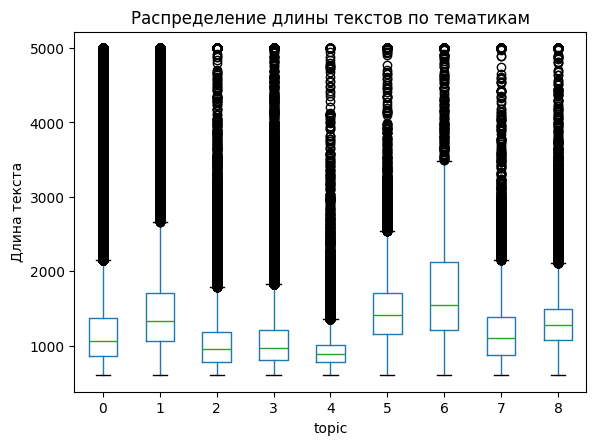

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
all_data.boxplot(column="len", by="topic", grid=False)
plt.suptitle("")
plt.title("Распределение длины текстов по тематикам")
plt.ylabel("Длина текста")
plt.show()

### Вывод

Из графика видно, что распределения длин текстов различаются в зависимости от тематики. В большинстве классов медианная длина текста находится в диапазоне 900–1500 символов.

Наиболее длинные тексты в среднем наблюдаются в темах «Строительство», «Забота о себе» и «Экономика», тогда как тема  «Спорт» имеют более короткие и компактные тексты.

In [84]:
display(all_data.head())
all_data.shape

,content,topic,content_clean,len
0,Россиянам дали советы при выборе чая. Рекоменд...,0,россиянам дали советы при выборе чая. рекоменд...,1773
1,Спикер Госдумы Вячеслав Володин назвал угрозой...,0,спикер госдумы вячеслав володин назвал угрозой...,1396
2,В Москве полицейские застрелили мужчину при по...,2,в москве полицейские застрелили мужчину при по...,879
3,В ЗАГСе Казани официально вступила в брак пара...,0,в загсе казани официально вступила в брак пара...,894
4,Россиян предостерегли от нового способа кражи ...,0,россиян предостерегли от нового способа кражи ...,1362


(629638, 4)

In [85]:
train_news = pd.DataFrame({
    "content": all_data["content_clean"],
    "topic": all_data["topic"]
})

output_path = "train_news.csv"

train_news.to_csv(output_path, index=False)

### Токенизация и работа со стоп-словами

Токенизация текстов и удаление стоп-слов выполняются на этапе обучения моделей во втором ноутбуке. Для этого используются стандартные инструменты библиотеки scikit-learn (`CountVectorizer`, `TfidfVectorizer`), которые встраиваются в обучающий пайплайн.

В данном ноутбуке основное внимание уделено сбору, очистке, валидации и анализу данных, тогда как текстовая предобработка и обучение моделей вынесены в отдельный этап.